In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [ ]:
df = pd.read_csv("/kaggle/input/normalcsv/dataset_labels.csv")
print(df.head())

                                          image_path          label
0              Biodegradable/leaf_waste/00000042.jpg  Biodegradable
1              Biodegradable/leaf_waste/00000080.jpg  Biodegradable
2              Biodegradable/leaf_waste/00000113.jpg  Biodegradable
3  Biodegradable/leaf_waste/a6876e29-dc0f-4716-bd...  Biodegradable
4              Biodegradable/leaf_waste/00000115.jpg  Biodegradable


In [ ]:
dff=pd.DataFrame(df)
dff.tail()

,image_path,label
31069,Recyclable/paper_cups/Image_60.png,Recyclable
31070,Recyclable/paper_cups/Image_132.png,Recyclable
31071,Recyclable/paper_cups/Image_4 (2).png,Recyclable
31072,Recyclable/paper_cups/Image_165.png,Recyclable
31073,Recyclable/paper_cups/Image_27 (2).png,Recyclable


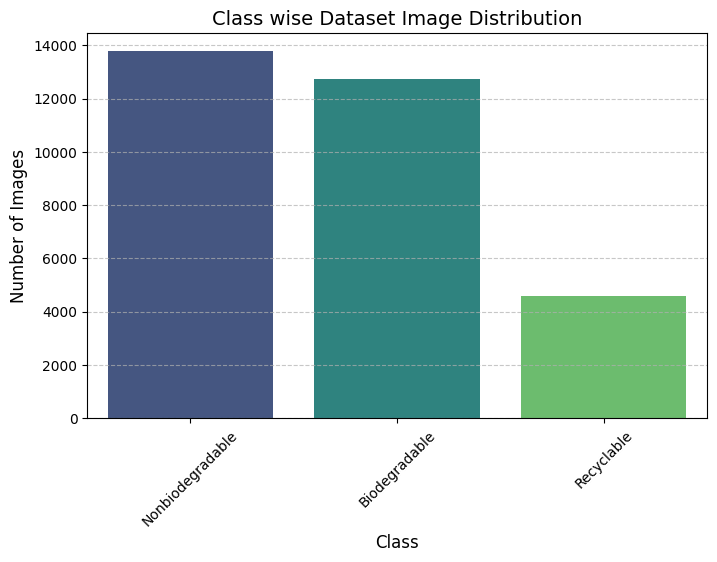

In [ ]:
# Load dataset labels CSV
csv_path = "/kaggle/input/normalcsv/dataset_labels.csv"
df = pd.read_csv(csv_path)

# Count images per class
class_counts = df["label"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add labels
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class wise Dataset Image Distribution", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
df = pd.read_csv("/kaggle/input/normalcsv/dataset_labels.csv")
print(df["label"].value_counts())

label
Nonbiodegradable    13774
Biodegradable       12728
Recyclable           4572
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
from PIL import ImageFile
import os

# Fix for truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "/kaggle/input/dataset/DATASET"

# Data Preprocessing & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training",
    shuffle=True
)

val_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation",
    shuffle=False
)

# Compute class weights
y_train = train_ds.classes
weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = tf.constant(weights_array, dtype=tf.float32)
print("Class Weights:", weights_array)


Found 26294 images belonging to 3 classes.
Found 6571 images belonging to 3 classes.
Class Weights: [0.75453398 0.7953418  2.39602697]


In [ ]:
# Custom loss function: Sparse Weighted Cross-Entropy
def sparse_weighted_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    weights = tf.gather(class_weights_tensor, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weights

# Base model: ResNet50
base_model = ResNet50(
    weights='/kaggle/input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True

# Fine-tuning: Unfreeze last few layers
fine_tune_at = len(base_model.layers) - 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(train_ds.class_indices), activation='softmax')(x)

# Final model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sparse_weighted_crossentropy,
    metrics=["accuracy"]
)

# Model checkpoint callback
checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max"
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

# Load and evaluate the best model
best_model = tf.keras.models.load_model(
    "/kaggle/working/best_model.keras",
    custom_objects={"sparse_weighted_crossentropy": sparse_weighted_crossentropy}
)

loss, acc = best_model.evaluate(val_ds)
print(f"Best Validation Accuracy after Fine-Tuning: {acc * 100:.2f}%")

Epoch 1/20


Exception ignored in: <function AtomicFunction.__del__ at 0x7da364edb1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
  
KeyboardInterrupt: 

KeyboardInterrupt



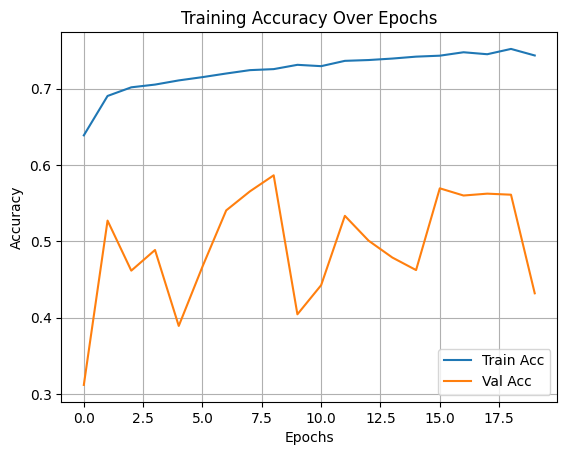

In [ ]:
# Plot training results
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


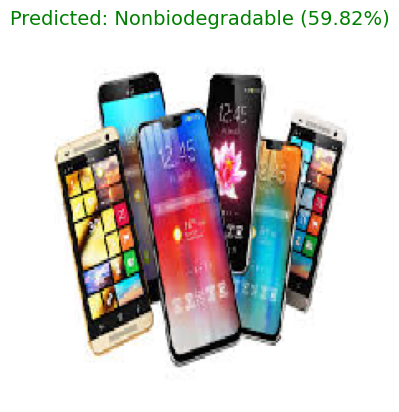

In [ ]:
from tensorflow.keras.preprocessing import image
class_labels = ['Biodegradable', 'Nonbiodegradable', 'Recyclable']

# Load your best model (important!)
model = tf.keras.models.load_model(
    "/kaggle/working/best_model.keras",
    custom_objects={"sparse_weighted_crossentropy": sparse_weighted_crossentropy}
)

def predict_and_plot(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_expanded)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_labels[predicted_class]

    # Show the image and prediction
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)", fontsize=14, color='green')
    plt.show()

# Example usage
img_path = "/kaggle/input/testting/mobele.jpg"
predict_and_plot(img_path)


I used the best model but we have to use the final model to resume training from where we left

In [ ]:
model = tf.keras.models.load_model(
    '/kaggle/working/best_model.keras',
    custom_objects={'sparse_weighted_crossentropy': sparse_weighted_crossentropy}
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sparse_weighted_crossentropy,
    metrics=['accuracy']
)
history_more = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,        # Total epochs you want
    initial_epoch=20, # Start from epoch 20
    callbacks=[checkpoint]
)

Epoch 21/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 449s 523ms/step - accuracy: 0.7252 - loss: 0.6693 - val_accuracy: 0.5375 - val_loss: 1.1700
Epoch 22/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 420s 507ms/step - accuracy: 0.7340 - loss: 0.6591 - val_accuracy: 0.4731 - val_loss: 1.2119
Epoch 23/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 419s 506ms/step - accuracy: 0.7346 - loss: 0.6531 - val_accuracy: 0.5946 - val_loss: 1.3499
Epoch 24/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 417s 504ms/step - accuracy: 0.7423 - loss: 0.6463 - val_accuracy: 0.4205 - val_loss: 1.7616
Epoch 25/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 415s 502ms/step - accuracy: 0.7311 - loss: 0.6440 - val_accuracy: 0.4121 - val_loss: 1.1994
Epoch 26/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 421s 509ms/step - accuracy: 0.7380 - loss: 0.6410 - val_accuracy: 0.5775 - val_loss: 1.0683
Epoch 27/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 423s 511ms/step - accuracy: 0.7493 - loss: 0.6298 - val_accuracy: 0.5858 - val_loss: 1.0958
Epoch 28/30
822/822 ━━━━━━━━━━━━━━━━━━━━ 421s 509ms/step - accuracy: 

In [ ]:
val_acc_list = history_more.history['val_accuracy']
print(f" Best Validation Accuracy: {val_acc_list[2] * 100:.2f}%")


 Best Validation Accuracy: 59.46%


In [ ]:
model = tf.keras.models.load_model(
    '/kaggle/input/model_58/keras/default/1/best_model_v2_58.keras',
    custom_objects={'sparse_weighted_crossentropy': sparse_weighted_crossentropy}
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sparse_weighted_crossentropy,
    metrics=['accuracy']
)
history_more = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,        # Total epochs you want
    initial_epoch=20, # Start from epoch x
    callbacks=[checkpoint]
)

Epoch 21/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 466s 544ms/step - accuracy: 0.7314 - loss: 0.6621 - val_accuracy: 0.4657 - val_loss: 1.6611
Epoch 22/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 452s 546ms/step - accuracy: 0.7268 - loss: 0.6587 - val_accuracy: 0.4352 - val_loss: 1.8957
Epoch 23/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 443s 535ms/step - accuracy: 0.7348 - loss: 0.6521 - val_accuracy: 0.5757 - val_loss: 1.0911
Epoch 24/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 438s 529ms/step - accuracy: 0.7396 - loss: 0.6430 - val_accuracy: 0.4931 - val_loss: 1.6679
Epoch 25/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 439s 530ms/step - accuracy: 0.7365 - loss: 0.6400 - val_accuracy: 0.5291 - val_loss: 1.2769
Epoch 26/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 436s 527ms/step - accuracy: 0.7431 - loss: 0.6347 - val_accuracy: 0.4818 - val_loss: 2.6800
Epoch 27/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 437s 528ms/step - accuracy: 0.7425 - loss: 0.6357 - val_accuracy: 0.4925 - val_loss: 1.4127
Epoch 28/40
822/822 ━━━━━━━━━━━━━━━━━━━━ 437s 528ms/step - accuracy: 

In [ ]:
_, val_acc = tf.keras.models.load_model("/kaggle/working/best_model.keras", custom_objects={"sparse_weighted_crossentropy": sparse_weighted_crossentropy}).evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 407ms/step - accuracy: 0.4517 - loss: 1.3128
Validation Accuracy: 58.20%


In [ ]:
val_acc_list = history_more.history['val_accuracy']
print(f" Best Validation Accuracy: {val_acc_list[13] * 100:.2f}%")


 Best Validation Accuracy: 59.00%


In [ ]:
model = tf.keras.models.load_model(
    '/kaggle/input/model_58/keras/default/1/best_model_v2_58.keras',
    custom_objects={'sparse_weighted_crossentropy': sparse_weighted_crossentropy}
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sparse_weighted_crossentropy,
    metrics=['accuracy']
)

history_more = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,         # Total epochs you want
    initial_epoch=30,  # Start from epoch x
    callbacks=[checkpoint]
)

#Save the final model after training
model.save('/kaggle/working/final_model_after_50_epochs.keras')

Epoch 31/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 87/822 ━━━━━━━━━━━━━━━━━━━━ 5:13 427ms/step - accuracy: 0.7294 - loss: 0.6713

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


822/822 ━━━━━━━━━━━━━━━━━━━━ 501s 584ms/step - accuracy: 0.7280 - loss: 0.6674 - val_accuracy: 0.5259 - val_loss: 1.0276
Epoch 32/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 534s 645ms/step - accuracy: 0.7325 - loss: 0.6558 - val_accuracy: 0.5310 - val_loss: 1.2309
Epoch 33/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 487s 587ms/step - accuracy: 0.7337 - loss: 0.6582 - val_accuracy: 0.4926 - val_loss: 1.2442
Epoch 34/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 529s 640ms/step - accuracy: 0.7352 - loss: 0.6463 - val_accuracy: 0.5331 - val_loss: 1.1043
Epoch 35/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 509s 616ms/step - accuracy: 0.7280 - loss: 0.6476 - val_accuracy: 0.5147 - val_loss: 0.9819
Epoch 36/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 532s 642ms/step - accuracy: 0.7439 - loss: 0.6269 - val_accuracy: 0.4833 - val_loss: 2.0401
Epoch 37/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 633s 765ms/step - accuracy: 0.7496 - loss: 0.6325 - val_accuracy: 0.4737 - val_loss: 2.4315
Epoch 38/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 616s 744ms/step - accuracy: 0.7324 - los

In [ ]:
# Load both models
model1 = tf.keras.models.load_model(
    '/kaggle/input/model_epoch_50/keras/default/1/best_model (2).keras',
    custom_objects={'sparse_weighted_crossentropy': sparse_weighted_crossentropy}
)

model2 = tf.keras.models.load_model(
    '/kaggle/input/model_58/keras/default/1/best_model_v2_58.keras',
    custom_objects={'sparse_weighted_crossentropy': sparse_weighted_crossentropy}
)

# Evaluate on validation set
_, acc1 = model1.evaluate(val_ds)
_, acc2 = model2.evaluate(val_ds)

# Print results
print(f"Model After 50 Epoch Accuracy: {acc1 * 100:.2f}%")
print(f"Model After 40 Epoch Accuracy: {acc2 * 100:.2f}%")


206/206 ━━━━━━━━━━━━━━━━━━━━ 100s 453ms/step - accuracy: 0.5464 - loss: 0.8739
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 431ms/step - accuracy: 0.4806 - loss: 0.9407
Model After 50 Epoch Accuracy: 62.09%
Model After 40 Epoch Accuracy: 58.68%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def sparse_weighted_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    weights = tf.gather(class_weights_tensor, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weights

# Load the model
model = tf.keras.models.load_model(
    '/kaggle/input/64-model/keras/default/1/model64 (1).keras',
    custom_objects={'sparse_weighted_crossentropy': sparse_weighted_crossentropy}
)

# === Evaluation Loop ===

y_true = []
y_pred = []

images_processed = 0
limit = val_ds.samples  # Total validation samples

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)

    batch_size = len(labels)
    if images_processed + batch_size > limit:
        remaining = limit - images_processed
        y_true.extend(labels[:remaining])
        y_pred.extend(preds[:remaining])
        images_processed += remaining
        print(f"Images processed: {images_processed}/{limit}")
        break
    else:
        y_true.extend(labels)
        y_pred.extend(preds)
        images_processed += batch_size
        print(f"Images processed: {images_processed}/{limit}")

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# === Performance Metrics ===

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n Final Performance Metrics")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1 Score (macro):  {f1:.4f}")

# === Confusion Matrix ===

class_names = ["Biodegradable", "Nonbiodegradable", "Recyclable"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

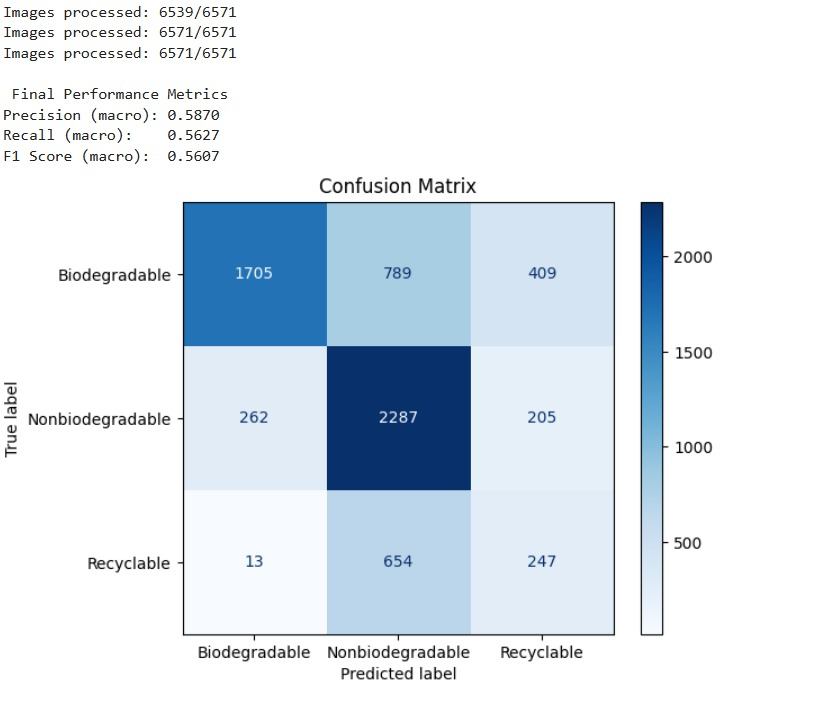